In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

다수결 투표를 하듯이 몇 개의 예측기들로 부터 예측을 수집해서 가장 많이 나온 예측을 사용

예측기 집합을 앙상블이라고 하기 때문에 앙상블 학습, 앙상블 메서드라고 부름

In [8]:
#51% 확률로 앞면이 나오는 이상한 동전
heads_proba = 0.51
coin_tosses = np.random.rand(10000, 10) #10000번씩 던지는 실험을 10번 수행 
print(coin_tosses.shape)
print(coin_tosses[:5]) #0-1사이의 랜덤한 값
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) #51%의 확률에 포함되는 것들만 추리고
print(coin_tosses[:5]) # True = 1, False = 0으로 변환

print(np.cumsum(coin_tosses, axis=0)) #행 방향(위에서 아래로 값들을 누적시키며 더해간다)
#각 행은 n번째 동전을 던졌을 때 까지 앞면이 나온 횟수
#맨 아래 행은 10000번 동전을 던졌을 때 앞면이 나온 전체 횟수

cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
#각 행(n번째 동전 던짐)에 대해서 n번 던져서 앞면이 나올 확률 계산

#마지막 행에는 10000번 던졌을 때 앞면이 나올 확률
print(cumulative_heads_ratio[-1])

(10000, 10)
[[0.15664319 0.12704905 0.56692278 0.15687988 0.14268354 0.54398067
  0.79836708 0.15005058 0.02500515 0.89698928]
 [0.34063655 0.22217904 0.80443128 0.86131407 0.3876385  0.97918347
  0.45660748 0.11016414 0.63339311 0.22968015]
 [0.40404355 0.798767   0.68542868 0.58807461 0.28004787 0.12489304
  0.19285199 0.81653844 0.08515485 0.79808445]
 [0.01155878 0.92624188 0.67259052 0.78982346 0.21887591 0.36998318
  0.89825902 0.71449566 0.81537214 0.51065649]
 [0.0268832  0.79652504 0.57062731 0.1201044  0.2439332  0.0392627
  0.58673975 0.67389834 0.60398204 0.2268638 ]]
[[0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 1]
 [1 0 0 1 1 1 0 1 0 1]
 [1 1 0 0 1 0 0 1 0 1]]
[[   0    1    0 ...    1    0    1]
 [   1    1    1 ...    1    0    1]
 [   1    2    1 ...    1    1    2]
 ...
 [5201 5112 5072 ... 5084 5113 5091]
 [5202 5112 5073 ... 5084 5113 5092]
 [5202 5113 5073 ... 5084 5114 5092]]
[0.5202 0.5113 0.5073 0.5057 0.5069 0.5212 0.5168 0.5084 0.5114 0.509

그림 저장: law_of_large_numbers_plot


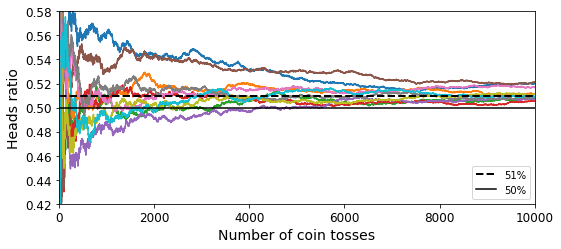

In [9]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [11]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_clf),
        ("rf", rnd_clf),
        ("svc", svm_clf)
    ],
    voting="hard"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [15]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


In [19]:
#간접 투표

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_clf),
        ("rf", rnd_clf),
        ("svc", svm_clf)
    ],
    voting="soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [24]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅과 페이스팅

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#배깅으로 훈련(각 훈련 세트에서 중복 허용)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, #결정 트리 분류기 500개의 앙상블
    max_samples=100, #각 분류기는 훈련 세트에서 무작위로 선택된 100개의 샘플로 훈련
    bootstrap=True, #무작위 샘플에서 중복 허용
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.92

In [29]:
#단일 결정 트리

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.856


In [28]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: dicision_tree_without_and_with_bagging_plot


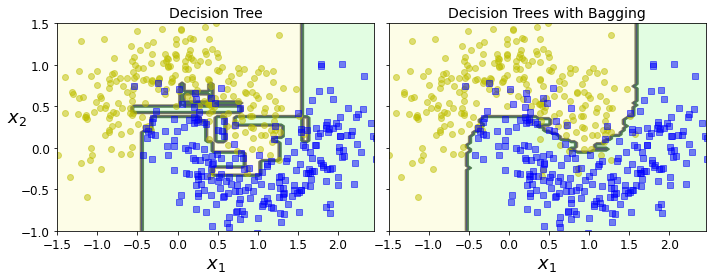

In [30]:
fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

save_fig("dicision_tree_without_and_with_bagging_plot")
plt.show()

배깅 앙상블이 오차는 큰 차이가 없지만 결정 경계는 보다 명확하다.

In [31]:
#배깅에서 선택되지 않은 out of bag(oob)샘플을 이용한 평가

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, #결정 트리 분류기 500개의 앙상블
    max_samples=100, #각 분류기는 훈련 세트에서 무작위로 선택된 100개의 샘플로 훈련
    bootstrap=True, #무작위 샘플에서 중복 허용
    n_jobs=-1,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [32]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred), bag_clf.oob_score_

(0.912, 0.9226666666666666)

# 랜덤 포레스트

BaggingClassifer에 DecisionTreeClassfier를 사용하는 대신에 결정 트리에 최적화된 RandomForestClassifier를 제공

In [33]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

랜덤 포레스트는 트리의 노드를 분할 할 때, 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 추가

트리를 더 다양하게 만들고, 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 좋은 모델 생성

In [34]:
#위에서 생성한 것과 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, #결정 트리 분류기 500개의 앙상블
    max_samples=1.0, #각 분류기는 훈련 세트에서 무작위로 선택된 100개의 샘플로 훈련
    bootstrap=True, #무작위 샘플에서 중복 허용
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다

In [39]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris.data, iris.target)
for name, score in zip(iris.feature_names, rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11465786651420605
sepal width (cm) 0.026191312257157286
petal length (cm) 0.420012850748108
petal width (cm) 0.4391379704805288


꽃잎의 길이와 너비가 중요하며, 꽃받침의 길이와 너비는 덜 중요함

In [35]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
print(mnist.target[:5])
mnist.target = mnist.target.astype(np.uint8) #문자를 숫자로 변경

['5' '0' '4' '1' '9']


In [36]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rnd_clf.fit(mnist.data, mnist.target)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [37]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot,
              interpolation="nearest")
    plt.axis("off")

(784,)
그림 저장: mnist_feature_importance_plot


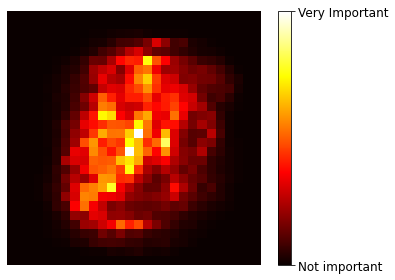

In [38]:
print(rnd_clf.feature_importances_.shape)
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very Important"])

save_fig("mnist_feature_importance_plot")
plt.show()

# 에이다 부스트

adaptive boosting의 줄임말

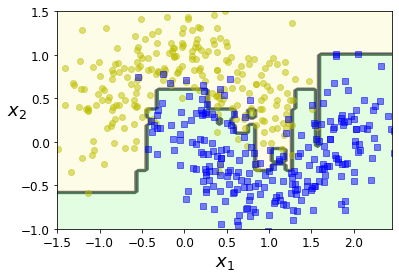

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

그림 저장: boosting_plot


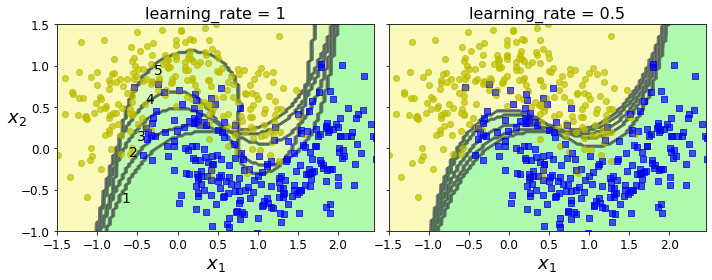

In [41]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) #최초 샘플의 가중치는 1
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42) #규제를 강하게 한 SVM 분류기
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) #예측이 틀린 샘플에 대해 가중치 증가
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

에이다 부스트 앙상블이 훈련 세트에 과대 적합되는 추정기 수를 줄이거나 추정기의 규제를 더 강하게(아래 처럼)

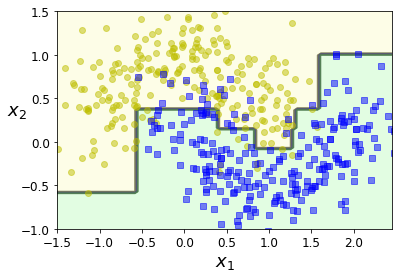

In [42]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, max_leaf_nodes=16), #규체 추가
    n_estimators=100, #추정기 수 감소
    algorithm="SAMME.R",
    learning_rate=0.1, #학습률 감소
    random_state=42
)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

# 그래디언트 부스팅

In [43]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [45]:
#첫 번째 예측기에서 생긴 잔여 오차에 두번째 결정 트리 훈련
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [46]:
#두 번째 예측기에서 생긴 잔여 오차에 두번째 결정 트리 훈련
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [49]:
X_new = np.array([[0.8]])

In [50]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

In [58]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X.ravel(), y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


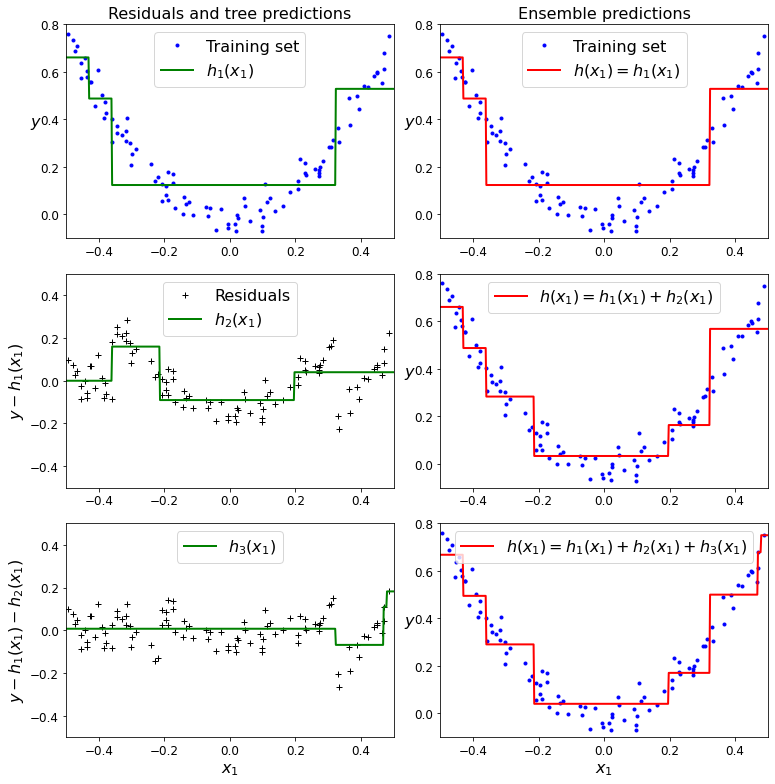

In [59]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

왼쪽은 각 트리의 예측

첫 번째 트리는 평소와 같이 훈련되고, 나머지 트리는 전 트리의 잔여 오차에서 훈련

오른쪽은 각 앙상블의 예측

최적의 트리 수를 찾기 위해서 조기 종료 기법을 사용할 수 있음.

# XGBoost

익스트림 그래디언트 부스팅의 약자

pip install xgboost 로 설치 필요

In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49)

In [62]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print("Validation MSE:", test_error)

Validation MSE: 0.00400040950714611


In [63]:
xgb_reg.fit(X_train, y_train,
           eval_set=[(X_test, y_test)],
           early_stopping_rounds=2)#조기 종료 세팅 2번 훈련 반복 마다 향상이 있는지 체크, 없다면 종료(기본 num_boost_rounds=10)
y_pred = xgb_reg.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print("Validation MSE:", test_error)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


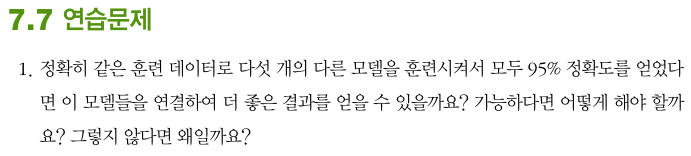
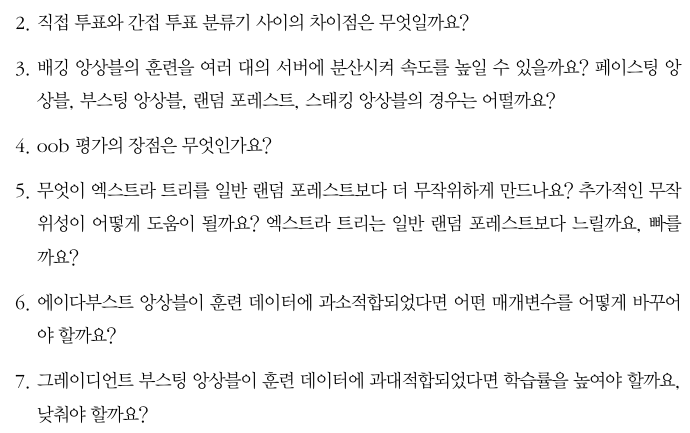

1. 다섯 개의 모델을 연결해서 앙상블을 만들면 더 나은 결과를 기대할 수 있음. 서로 다른 분류기라면 더 좋고, 서로 다른 샘플에서 훈련되었다면 더더욱 좋다.


2. 직접 투표는 각 분류기의 선택을 카운트해서 가장 많이 투표를 받은 클래스를 선택, 간접 투표는 각 클래스의 평균적인 확률 추정값을 계산해서 가장 높은 확률을 가진 클래스를 고른다.


3. 배깅 앙상블의 각 예측기는 독립적이므로 분산 가능. 페이스팅과 랜덤 포레스트도 가능. 부스팅은 이전 예측기를 기반으로 만들어 지므로 분산 불가능. 스태깅은 한 층의 예측기가 독립적이므로 가능하지만, 이전 층의 예측기들이 모두 훈련된 다음에나 가능


4. 배깅 앙상블에서 사용되지 않은 샘플을 이용해서 각 예측기를 평가, 추가적인 검증 세트가 없어도 편향되지 않게 앙상블을 평가


5. 랜덤 포레스트에서 트리가 분할 될 때 각 노드에서 특성의 일부를 무작위로 선택함. 엑스트라 트리는 각 특성에 대해 최선의 임계점이 아닌 랜덤한 임계점 사용. 추가적인 무작위성이 규제 처럼 작동하므로 랜덤 포레스트보다 과대적합 가능성 낮음.  
   훈련시는 더 빠르지만 예측은 동일함


6. 과소 적합이라면 예측기 수를 늘리거나 예측기의 규제 하이퍼파라미터를 감소 및 학습률 증가 가능


7. 학습률을 감소시키고, 예측기 수를 찾기 위해 조기 종료 사용 가능

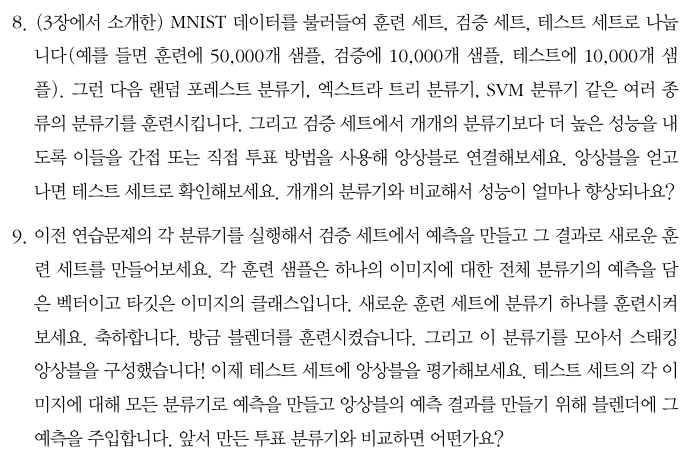

In [65]:
#연습문제 8

#테스트에 10000개 샘플
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)

#나머지 60000개 중에 테스트에 50000개 검증에 10000개
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (50000,), (10000,), (10000,))

In [66]:
#여러 분류기 훈련

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ext_clf = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [rnd_clf, ext_clf, svm_clf, mlp_clf]
for est in estimators:
    print("Training the", est)
    est.fit(X_train, y_train)

Training the RandomForestClassifier(n_jobs=-1, random_state=42)
Training the ExtraTreesClassifier(n_jobs=-1, random_state=42)
Training the LinearSVC(random_state=42)


c:\sources\python\deeplearning\dl\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training the MLPClassifier(random_state=42)


In [67]:
[est.score(X_val, y_val) for est in estimators]

[0.9692, 0.9715, 0.8695, 0.9655]

선형 분류기의 성능이 떨어지지만 투표 기반 분류기의 성능을 향상 시킬 수 있으므로 그대로 둠

In [68]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", rnd_clf),
    ("extra_trees_clf", ext_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

c:\sources\python\deeplearning\dl\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('svm_clf', LinearSVC(random_state=42)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [69]:
voting_clf.score(X_val, y_val)

0.9711

In [70]:
#예측률이 가장 낮은 SVM을 제거해보자.

voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [72]:
voting_clf.estimators_

[RandomForestClassifier(n_jobs=-1, random_state=42),
 ExtraTreesClassifier(n_jobs=-1, random_state=42),
 LinearSVC(random_state=42),
 MLPClassifier(random_state=42)]

In [73]:
#예측기 목록은 그대로 이므로, 훈련된 예측기 목록에서 SVM 제거

del voting_clf.estimators_[2]

In [74]:
#다시 평가

voting_clf.score(X_val, y_val)

0.9738

In [75]:
#간접 투표 방식으로 변경
voting_clf.voting = "soft"

voting_clf.score(X_val, y_val)

0.9713

In [76]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9706

In [78]:
[est.score(X_val, y_val) for est in voting_clf.estimators_]

[0.9692, 0.9715, 0.9655]

In [79]:
# 연습 문제 9

#이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고, 에측 결과로 훈련 세트를 만든다
#각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 에측을 담은 벡터, 타깃은 이미지 클래스
#새로운 훈련 세트에 분류기 하나를 훈련

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, est in enumerate(estimators):
    X_val_predictions[:, index] = est.predict(X_val)
    
X_val_predictions, X_val_predictions.shape

(array([[5., 5., 5., 5.],
        [8., 8., 8., 8.],
        [2., 2., 2., 2.],
        ...,
        [7., 7., 7., 7.],
        [6., 6., 6., 6.],
        [7., 7., 7., 7.]], dtype=float32),
 (10000, 4))

In [80]:
rnd_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, n_jobs=-1)
rnd_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [81]:
rnd_blender.oob_score_

0.9681

In [82]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, est in enumerate(estimators):
    X_test_predictions[:, index] = est.predict(X_test)

In [83]:
y_pred = rnd_blender.predict(X_test_predictions)

In [84]:
accuracy_score(y_test, y_pred)

0.9668

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기보다 성능이 낮다.